## 1. Import Libraries

In [1]:
# Standard libraries
import os
import sys
import json
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Any

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models import VGG19_Weights

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

print("✅ Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

✅ Libraries imported successfully!
PyTorch version: 2.7.1+cu118
CUDA available: True
GPU: NVIDIA GeForce MX450


## 2. Setup Paths and Configuration

In [2]:
# Project paths
project_root = Path(r'd:\Projects\AI-Virtual-TryOn')
output_dir = project_root / 'outputs' / 'loss_functions'
output_dir.mkdir(parents=True, exist_ok=True)

# Load model configuration
with open(project_root / 'outputs' / 'model_architecture' / 'model_architecture_config.json', 'r') as f:
    model_config = json.load(f)

print(f"📁 Project Root: {project_root}")
print(f"📁 Output Directory: {output_dir}")
print(f"\n✅ Loaded model configuration")

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\n🖥️ Using device: {device}")

# Loss weights configuration
loss_config = {
    'lambda_gan': 1.0,        # GAN loss weight
    'lambda_perceptual': 10.0, # Perceptual loss weight
    'lambda_l1': 10.0,        # L1 reconstruction weight
    'lambda_fm': 10.0,        # Feature matching weight
    'vgg_layers': ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']
}

print(f"\n📊 Loss Configuration:")
for key, value in loss_config.items():
    print(f"   {key}: {value}")

📁 Project Root: d:\Projects\AI-Virtual-TryOn
📁 Output Directory: d:\Projects\AI-Virtual-TryOn\outputs\loss_functions

✅ Loaded model configuration

🖥️ Using device: cuda

📊 Loss Configuration:
   lambda_gan: 1.0
   lambda_perceptual: 10.0
   lambda_l1: 10.0
   lambda_fm: 10.0
   vgg_layers: ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']


## 3. VGG19 Perceptual Loss Network

In [3]:
class VGGPerceptualLoss(nn.Module):
    """
    Perceptual loss using VGG19 features.
    Computes L1 distance between features from multiple layers.
    """
    
    def __init__(self, 
                 layers: List[str] = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1'],
                 weights: Optional[List[float]] = None):
        super().__init__()
        
        # Load pretrained VGG19
        vgg = models.vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features
        
        # Freeze VGG parameters
        for param in vgg.parameters():
            param.requires_grad = False
        
        # Layer mapping
        self.layer_name_mapping = {
            'relu1_1': '1',
            'relu1_2': '3',
            'relu2_1': '6',
            'relu2_2': '8',
            'relu3_1': '11',
            'relu3_2': '13',
            'relu3_3': '15',
            'relu3_4': '17',
            'relu4_1': '20',
            'relu4_2': '22',
            'relu4_3': '24',
            'relu4_4': '26',
            'relu5_1': '29',
            'relu5_2': '31',
            'relu5_3': '33',
            'relu5_4': '35',
        }
        
        # Build feature extractors
        self.features = nn.ModuleDict()
        for layer_name in layers:
            layer_idx = int(self.layer_name_mapping[layer_name])
            self.features[layer_name] = nn.Sequential(*[vgg[i] for i in range(layer_idx + 1)])
        
        # Layer weights (equal if not specified)
        self.weights = weights if weights is not None else [1.0] * len(layers)
        
        # Normalization for ImageNet
        self.register_buffer('mean', torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer('std', torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))
    
    def normalize(self, x: torch.Tensor) -> torch.Tensor:
        """
        Normalize from [-1, 1] to ImageNet normalization.
        """
        # Convert from [-1, 1] to [0, 1]
        x = (x + 1) / 2
        # Apply ImageNet normalization
        x = (x - self.mean) / self.std
        return x
    
    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """
        Compute perceptual loss between x and y.
        
        Args:
            x: Generated image [B, 3, H, W]
            y: Target image [B, 3, H, W]
        
        Returns:
            Perceptual loss (scalar)
        """
        # Normalize inputs
        x = self.normalize(x)
        y = self.normalize(y)
        
        loss = 0.0
        
        # Extract features and compute loss
        for (layer_name, feature_extractor), weight in zip(self.features.items(), self.weights):
            x_feat = feature_extractor(x)
            y_feat = feature_extractor(y)
            
            # L1 distance between features
            loss += weight * F.l1_loss(x_feat, y_feat)
        
        return loss


print("✅ VGGPerceptualLoss defined")
print("   - Extracts features from VGG19")
print("   - Computes L1 distance across multiple layers")
print("   - Uses ImageNet pretrained weights")

✅ VGGPerceptualLoss defined
   - Extracts features from VGG19
   - Computes L1 distance across multiple layers
   - Uses ImageNet pretrained weights


## 4. GAN Loss (Adversarial Loss)

In [4]:
class GANLoss(nn.Module):
    """
    GAN loss (adversarial loss).
    Supports multiple GAN objectives: vanilla, lsgan, hinge.
    """
    
    def __init__(self, gan_mode: str = 'lsgan', target_real_label: float = 1.0, 
                 target_fake_label: float = 0.0):
        """
        Args:
            gan_mode: Type of GAN loss ('vanilla', 'lsgan', 'hinge')
            target_real_label: Label for real images
            target_fake_label: Label for fake images
        """
        super().__init__()
        self.gan_mode = gan_mode
        self.real_label = target_real_label
        self.fake_label = target_fake_label
        
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
        elif gan_mode == 'hinge':
            # Hinge loss computed manually
            self.loss = None
        else:
            raise ValueError(f"Unsupported GAN mode: {gan_mode}")
    
    def get_target_tensor(self, prediction: torch.Tensor, target_is_real: bool) -> torch.Tensor:
        """
        Create target tensor with same size as prediction.
        """
        if target_is_real:
            target = torch.ones_like(prediction) * self.real_label
        else:
            target = torch.ones_like(prediction) * self.fake_label
        return target
    
    def forward(self, prediction: torch.Tensor, target_is_real: bool) -> torch.Tensor:
        """
        Compute GAN loss.
        
        Args:
            prediction: Discriminator output [B, 1, H, W]
            target_is_real: Whether target should be real (True) or fake (False)
        
        Returns:
            GAN loss (scalar)
        """
        if self.gan_mode == 'hinge':
            if target_is_real:
                # Discriminator loss for real: -min(0, -1 + D(x))
                loss = F.relu(1.0 - prediction).mean()
            else:
                # Discriminator loss for fake: -min(0, -1 - D(G(z)))
                loss = F.relu(1.0 + prediction).mean()
        else:
            target = self.get_target_tensor(prediction, target_is_real)
            loss = self.loss(prediction, target)
        
        return loss


print("✅ GANLoss defined")
print("   - Supports vanilla, LSGAN, and hinge loss")
print("   - Handles both real and fake predictions")

✅ GANLoss defined
   - Supports vanilla, LSGAN, and hinge loss
   - Handles both real and fake predictions


## 5. Feature Matching Loss

In [5]:
class FeatureMatchingLoss(nn.Module):
    """
    Feature matching loss.
    Matches intermediate discriminator features between real and fake images.
    """
    
    def __init__(self):
        super().__init__()
    
    def forward(self, fake_features: List[torch.Tensor], 
                real_features: List[torch.Tensor]) -> torch.Tensor:
        """
        Compute feature matching loss.
        
        Args:
            fake_features: List of feature maps from discriminator (fake images)
            real_features: List of feature maps from discriminator (real images)
        
        Returns:
            Feature matching loss (scalar)
        """
        loss = 0.0
        
        for fake_feat, real_feat in zip(fake_features, real_features):
            loss += F.l1_loss(fake_feat, real_feat.detach())
        
        return loss / len(fake_features)


print("✅ FeatureMatchingLoss defined")
print("   - Matches discriminator intermediate features")
print("   - Helps stabilize GAN training")

✅ FeatureMatchingLoss defined
   - Matches discriminator intermediate features
   - Helps stabilize GAN training


## 6. Combined Loss Module

In [6]:
class VITONLoss(nn.Module):
    """
    Combined loss for Virtual Try-On.
    Combines GAN, perceptual, L1, and feature matching losses.
    """
    
    def __init__(self, 
                 lambda_gan: float = 1.0,
                 lambda_perceptual: float = 10.0,
                 lambda_l1: float = 10.0,
                 lambda_fm: float = 10.0,
                 vgg_layers: List[str] = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1'],
                 gan_mode: str = 'lsgan'):
        super().__init__()
        
        # Loss weights
        self.lambda_gan = lambda_gan
        self.lambda_perceptual = lambda_perceptual
        self.lambda_l1 = lambda_l1
        self.lambda_fm = lambda_fm
        
        # Loss functions
        self.gan_loss = GANLoss(gan_mode=gan_mode)
        self.perceptual_loss = VGGPerceptualLoss(layers=vgg_layers)
        self.l1_loss = nn.L1Loss()
        self.fm_loss = FeatureMatchingLoss()
    
    def compute_generator_loss(self,
                              fake_image: torch.Tensor,
                              real_image: torch.Tensor,
                              disc_fake: torch.Tensor,
                              fake_features: Optional[List[torch.Tensor]] = None,
                              real_features: Optional[List[torch.Tensor]] = None) -> Dict[str, torch.Tensor]:
        """
        Compute generator losses.
        
        Args:
            fake_image: Generated image [B, 3, H, W]
            real_image: Target real image [B, 3, H, W]
            disc_fake: Discriminator output for fake image [B, 1, H', W']
            fake_features: Discriminator features for fake (optional)
            real_features: Discriminator features for real (optional)
        
        Returns:
            Dictionary with individual and total losses
        """
        losses = {}
        
        # GAN loss (fool discriminator)
        losses['gan'] = self.gan_loss(disc_fake, target_is_real=True) * self.lambda_gan
        
        # Perceptual loss
        losses['perceptual'] = self.perceptual_loss(fake_image, real_image) * self.lambda_perceptual
        
        # L1 reconstruction loss
        losses['l1'] = self.l1_loss(fake_image, real_image) * self.lambda_l1
        
        # Feature matching loss (if features provided)
        if fake_features is not None and real_features is not None:
            losses['fm'] = self.fm_loss(fake_features, real_features) * self.lambda_fm
        else:
            losses['fm'] = torch.tensor(0.0, device=fake_image.device)
        
        # Total loss
        losses['total'] = losses['gan'] + losses['perceptual'] + losses['l1'] + losses['fm']
        
        return losses
    
    def compute_discriminator_loss(self,
                                   disc_real: torch.Tensor,
                                   disc_fake: torch.Tensor) -> Dict[str, torch.Tensor]:
        """
        Compute discriminator losses.
        
        Args:
            disc_real: Discriminator output for real image [B, 1, H', W']
            disc_fake: Discriminator output for fake image [B, 1, H', W']
        
        Returns:
            Dictionary with individual and total losses
        """
        losses = {}
        
        # Real loss
        losses['real'] = self.gan_loss(disc_real, target_is_real=True)
        
        # Fake loss
        losses['fake'] = self.gan_loss(disc_fake, target_is_real=False)
        
        # Total loss (average of real and fake)
        losses['total'] = (losses['real'] + losses['fake']) * 0.5
        
        return losses


print("✅ VITONLoss defined")
print("   - Combines GAN, perceptual, L1, and feature matching losses")
print("   - Separate methods for generator and discriminator")
print("   - Returns detailed loss breakdown")

✅ VITONLoss defined
   - Combines GAN, perceptual, L1, and feature matching losses
   - Separate methods for generator and discriminator
   - Returns detailed loss breakdown


## 7. Initialize Loss Functions

In [7]:
# Initialize combined loss
criterion = VITONLoss(
    lambda_gan=loss_config['lambda_gan'],
    lambda_perceptual=loss_config['lambda_perceptual'],
    lambda_l1=loss_config['lambda_l1'],
    lambda_fm=loss_config['lambda_fm'],
    vgg_layers=loss_config['vgg_layers'],
    gan_mode='lsgan'
).to(device)

print("="*70)
print("🎯 LOSS FUNCTIONS INITIALIZED")
print("="*70)
print(f"\n✅ VITONLoss created and moved to {device}")
print(f"\n📊 Loss weights:")
print(f"   - GAN: {loss_config['lambda_gan']}")
print(f"   - Perceptual: {loss_config['lambda_perceptual']}")
print(f"   - L1: {loss_config['lambda_l1']}")
print(f"   - Feature Matching: {loss_config['lambda_fm']}")

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\nasir/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [06:03<00:00, 1.58MB/s] 


🎯 LOSS FUNCTIONS INITIALIZED

✅ VITONLoss created and moved to cuda

📊 Loss weights:
   - GAN: 1.0
   - Perceptual: 10.0
   - L1: 10.0
   - Feature Matching: 10.0


## 8. Test Loss Computations

In [8]:
print("="*70)
print("🧪 TESTING LOSS COMPUTATIONS")
print("="*70)

# Create dummy data
batch_size = 2
fake_image = torch.randn(batch_size, 3, 1024, 768).to(device)
real_image = torch.randn(batch_size, 3, 1024, 768).to(device)
disc_fake = torch.randn(batch_size, 1, 126, 94).to(device)
disc_real = torch.randn(batch_size, 1, 126, 94).to(device)

print(f"\n📥 Input shapes:")
print(f"   Fake image: {tuple(fake_image.shape)}")
print(f"   Real image: {tuple(real_image.shape)}")
print(f"   Disc fake: {tuple(disc_fake.shape)}")
print(f"   Disc real: {tuple(disc_real.shape)}")

# Test generator loss
print(f"\n🔷 Testing Generator Loss...")
gen_losses = criterion.compute_generator_loss(
    fake_image=fake_image,
    real_image=real_image,
    disc_fake=disc_fake
)

print(f"\n📊 Generator Losses:")
for name, loss in gen_losses.items():
    print(f"   {name:15s}: {loss.item():.4f}")

# Test discriminator loss
print(f"\n🔶 Testing Discriminator Loss...")
disc_losses = criterion.compute_discriminator_loss(
    disc_real=disc_real,
    disc_fake=disc_fake
)

print(f"\n📊 Discriminator Losses:")
for name, loss in disc_losses.items():
    print(f"   {name:15s}: {loss.item():.4f}")

print("\n" + "="*70)
print("\n✅ Loss computation test successful!")
print("="*70)

🧪 TESTING LOSS COMPUTATIONS

📥 Input shapes:
   Fake image: (2, 3, 1024, 768)
   Real image: (2, 3, 1024, 768)
   Disc fake: (2, 1, 126, 94)
   Disc real: (2, 1, 126, 94)

🔷 Testing Generator Loss...

📊 Generator Losses:
   gan            : 2.0081
   perceptual     : 116.0492
   l1             : 11.2854
   fm             : 0.0000
   total          : 129.3427

🔶 Testing Discriminator Loss...

📊 Discriminator Losses:
   real           : 2.0030
   fake           : 1.0033
   total          : 1.5032


✅ Loss computation test successful!


## 9. Test Individual Loss Components

In [9]:
print("="*70)
print("🔬 TESTING INDIVIDUAL LOSS COMPONENTS")
print("="*70)

# Test GAN loss
print("\n🔷 GAN Loss:")
gan_loss_real = criterion.gan_loss(disc_real, target_is_real=True)
gan_loss_fake = criterion.gan_loss(disc_fake, target_is_real=False)
print(f"   Real: {gan_loss_real.item():.4f}")
print(f"   Fake: {gan_loss_fake.item():.4f}")

# Test perceptual loss
print("\n🔷 Perceptual Loss:")
perceptual_loss = criterion.perceptual_loss(fake_image, real_image)
print(f"   Loss: {perceptual_loss.item():.4f}")

# Test L1 loss
print("\n🔷 L1 Loss:")
l1_loss = criterion.l1_loss(fake_image, real_image)
print(f"   Loss: {l1_loss.item():.4f}")

# Test with different similarity levels
print("\n🔬 Testing with different image similarities:")
identical = real_image.clone()
similar = real_image + torch.randn_like(real_image) * 0.1
different = torch.randn_like(real_image)

print("\n   Identical images:")
print(f"      Perceptual: {criterion.perceptual_loss(identical, real_image).item():.4f}")
print(f"      L1: {criterion.l1_loss(identical, real_image).item():.4f}")

print("\n   Similar images (noise=0.1):")
print(f"      Perceptual: {criterion.perceptual_loss(similar, real_image).item():.4f}")
print(f"      L1: {criterion.l1_loss(similar, real_image).item():.4f}")

print("\n   Different images (random):")
print(f"      Perceptual: {criterion.perceptual_loss(different, real_image).item():.4f}")
print(f"      L1: {criterion.l1_loss(different, real_image).item():.4f}")

print("\n" + "="*70)
print("\n✅ Individual loss tests successful!")
print("="*70)

🔬 TESTING INDIVIDUAL LOSS COMPONENTS

🔷 GAN Loss:
   Real: 2.0030
   Fake: 1.0033

🔷 Perceptual Loss:
   Loss: 11.6049

🔷 L1 Loss:
   Loss: 1.1285

🔬 Testing with different image similarities:

   Identical images:
      Perceptual: 0.0000
      L1: 0.0000

   Similar images (noise=0.1):
      Perceptual: 1.2907
      L1: 0.0798

   Different images (random):
      Perceptual: 11.5918
      L1: 1.1279


✅ Individual loss tests successful!


## 10. Visualize Loss Landscape

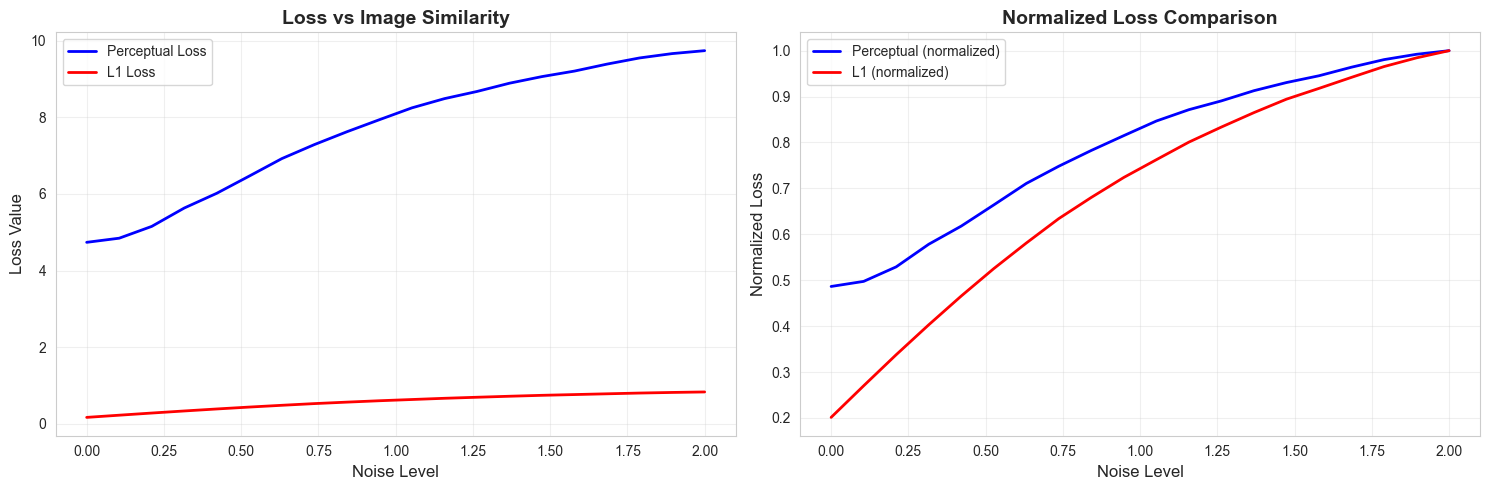

✅ Loss comparison visualization saved


In [10]:
def visualize_loss_comparison():
    """
    Visualize how different losses respond to image similarity.
    """
    # Create images with varying levels of similarity
    base_image = torch.randn(1, 3, 256, 256).to(device)
    noise_levels = np.linspace(0, 2, 20)
    
    perceptual_losses = []
    l1_losses = []
    
    for noise in noise_levels:
        noisy_image = base_image + torch.randn_like(base_image) * noise
        noisy_image = torch.clamp(noisy_image, -1, 1)
        
        with torch.no_grad():
            perceptual = criterion.perceptual_loss(noisy_image, base_image).item()
            l1 = criterion.l1_loss(noisy_image, base_image).item()
        
        perceptual_losses.append(perceptual)
        l1_losses.append(l1)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss curves
    ax1.plot(noise_levels, perceptual_losses, 'b-', linewidth=2, label='Perceptual Loss')
    ax1.plot(noise_levels, l1_losses, 'r-', linewidth=2, label='L1 Loss')
    ax1.set_xlabel('Noise Level', fontsize=12)
    ax1.set_ylabel('Loss Value', fontsize=12)
    ax1.set_title('Loss vs Image Similarity', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Normalized comparison
    perceptual_norm = np.array(perceptual_losses) / max(perceptual_losses)
    l1_norm = np.array(l1_losses) / max(l1_losses)
    
    ax2.plot(noise_levels, perceptual_norm, 'b-', linewidth=2, label='Perceptual (normalized)')
    ax2.plot(noise_levels, l1_norm, 'r-', linewidth=2, label='L1 (normalized)')
    ax2.set_xlabel('Noise Level', fontsize=12)
    ax2.set_ylabel('Normalized Loss', fontsize=12)
    ax2.set_title('Normalized Loss Comparison', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'loss_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✅ Loss comparison visualization saved")


visualize_loss_comparison()

## 11. Loss Weights Sensitivity Analysis

📊 LOSS WEIGHTS SENSITIVITY ANALYSIS

             config      total      gan  perceptual        l1  fm
           GAN only   1.961029 1.961029    0.000000  0.000000 0.0
    Perceptual only  11.850823 0.000000   11.850823  0.000000 0.0
            L1 only   1.129335 0.000000    0.000000  1.129335 0.0
Combined (balanced) 131.762604 1.961029  118.508232 11.293350 0.0


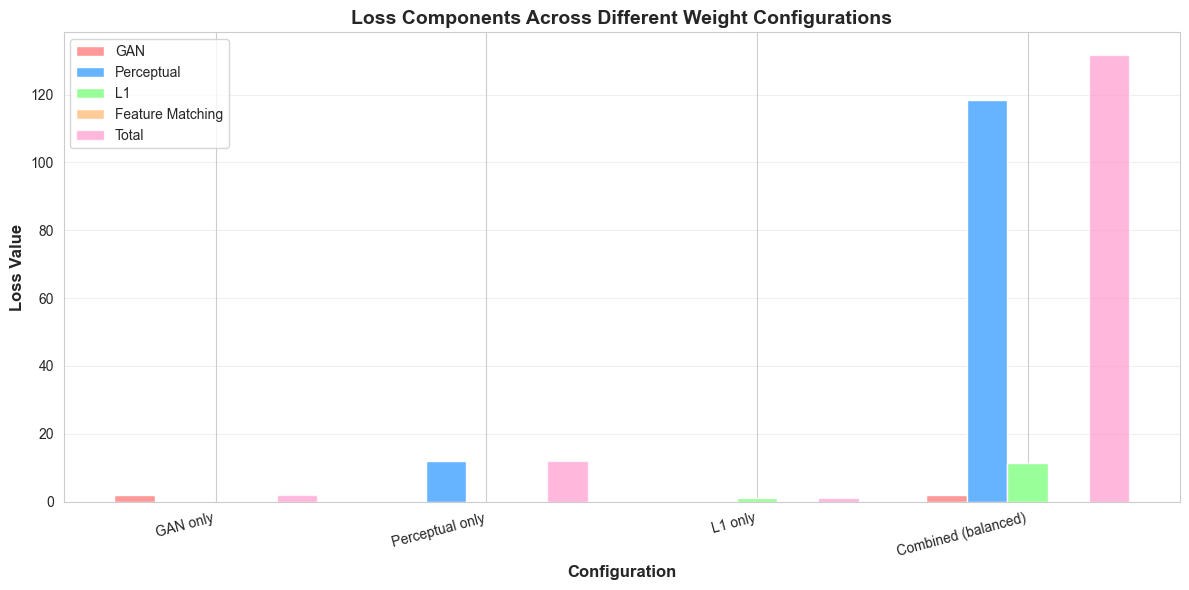


✅ Loss weights analysis complete


In [11]:
def analyze_loss_weights():
    """
    Analyze the impact of different loss weights.
    """
    # Sample data
    fake = torch.randn(1, 3, 256, 256).to(device)
    real = torch.randn(1, 3, 256, 256).to(device)
    disc = torch.randn(1, 1, 31, 23).to(device)
    
    # Test different weight configurations
    weight_configs = [
        {'lambda_gan': 1, 'lambda_perceptual': 0, 'lambda_l1': 0, 'lambda_fm': 0},
        {'lambda_gan': 0, 'lambda_perceptual': 1, 'lambda_l1': 0, 'lambda_fm': 0},
        {'lambda_gan': 0, 'lambda_perceptual': 0, 'lambda_l1': 1, 'lambda_fm': 0},
        {'lambda_gan': 1, 'lambda_perceptual': 10, 'lambda_l1': 10, 'lambda_fm': 10},
    ]
    
    config_names = ['GAN only', 'Perceptual only', 'L1 only', 'Combined (balanced)']
    
    results = []
    
    for config, name in zip(weight_configs, config_names):
        test_criterion = VITONLoss(**config, vgg_layers=loss_config['vgg_layers']).to(device)
        
        with torch.no_grad():
            losses = test_criterion.compute_generator_loss(fake, real, disc)
        
        results.append({
            'config': name,
            'total': losses['total'].item(),
            'gan': losses['gan'].item(),
            'perceptual': losses['perceptual'].item(),
            'l1': losses['l1'].item(),
            'fm': losses['fm'].item()
        })
    
    # Create DataFrame
    df = pd.DataFrame(results)
    
    print("="*70)
    print("📊 LOSS WEIGHTS SENSITIVITY ANALYSIS")
    print("="*70)
    print(f"\n{df.to_string(index=False)}")
    
    # Visualize
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(config_names))
    width = 0.15
    
    ax.bar(x - 2*width, df['gan'], width, label='GAN', color='#ff9999')
    ax.bar(x - width, df['perceptual'], width, label='Perceptual', color='#66b3ff')
    ax.bar(x, df['l1'], width, label='L1', color='#99ff99')
    ax.bar(x + width, df['fm'], width, label='Feature Matching', color='#ffcc99')
    ax.bar(x + 2*width, df['total'], width, label='Total', color='#ff99cc', alpha=0.7)
    
    ax.set_xlabel('Configuration', fontsize=12, fontweight='bold')
    ax.set_ylabel('Loss Value', fontsize=12, fontweight='bold')
    ax.set_title('Loss Components Across Different Weight Configurations', 
                fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(config_names, rotation=15, ha='right')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(output_dir / 'loss_weights_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Loss weights analysis complete")


analyze_loss_weights()

## 12. Save Loss Configuration

In [12]:
# Create detailed loss configuration
loss_full_config = {
    'loss_weights': {
        'lambda_gan': loss_config['lambda_gan'],
        'lambda_perceptual': loss_config['lambda_perceptual'],
        'lambda_l1': loss_config['lambda_l1'],
        'lambda_fm': loss_config['lambda_fm']
    },
    'gan_loss': {
        'type': 'lsgan',
        'target_real': 1.0,
        'target_fake': 0.0
    },
    'perceptual_loss': {
        'network': 'VGG19',
        'layers': loss_config['vgg_layers'],
        'pretrained': 'ImageNet'
    },
    'reconstruction_loss': {
        'type': 'L1',
        'pixel_wise': True
    },
    'feature_matching': {
        'enabled': True,
        'discriminator_features': True
    },
    'device': device
}

# Save configuration
config_path = output_dir / 'loss_config.json'
with open(config_path, 'w') as f:
    json.dump(loss_full_config, f, indent=2)

print("="*70)
print("💾 LOSS CONFIGURATION SAVED")
print("="*70)

print(f"\n📄 Config saved to: {config_path}")

print(f"\n📊 Summary:")
print(f"   - GAN weight: {loss_config['lambda_gan']}")
print(f"   - Perceptual weight: {loss_config['lambda_perceptual']}")
print(f"   - L1 weight: {loss_config['lambda_l1']}")
print(f"   - Feature matching weight: {loss_config['lambda_fm']}")
print(f"   - VGG layers: {len(loss_config['vgg_layers'])}")

print("\n" + "="*70)

💾 LOSS CONFIGURATION SAVED

📄 Config saved to: d:\Projects\AI-Virtual-TryOn\outputs\loss_functions\loss_config.json

📊 Summary:
   - GAN weight: 1.0
   - Perceptual weight: 10.0
   - L1 weight: 10.0
   - Feature matching weight: 10.0
   - VGG layers: 5



## 13. Summary

In [13]:
print("="*70)
print("🎉 LOSS FUNCTIONS COMPLETE!")
print("="*70)

print("\n✅ Completed Tasks:")
print("   1. ✓ Implemented VGG19 perceptual loss")
print("   2. ✓ Implemented GAN loss (LSGAN)")
print("   3. ✓ Implemented feature matching loss")
print("   4. ✓ Created combined VITONLoss module")
print("   5. ✓ Tested all loss computations")
print("   6. ✓ Tested individual loss components")
print("   7. ✓ Visualized loss comparisons")
print("   8. ✓ Analyzed loss weight sensitivity")
print("   9. ✓ Saved loss configuration")

print(f"\n📊 Loss Components:")
print(f"   🔷 GAN Loss:")
print(f"      - Type: LSGAN (Mean Squared Error)")
print(f"      - Weight: {loss_config['lambda_gan']}")
print(f"      - Purpose: Adversarial training for realistic generation")
print(f"   🔷 Perceptual Loss:")
print(f"      - Network: VGG19 (ImageNet pretrained)")
print(f"      - Layers: {len(loss_config['vgg_layers'])} layers")
print(f"      - Weight: {loss_config['lambda_perceptual']}")
print(f"      - Purpose: Feature-level similarity")
print(f"   🔷 L1 Loss:")
print(f"      - Type: Mean Absolute Error")
print(f"      - Weight: {loss_config['lambda_l1']}")
print(f"      - Purpose: Pixel-wise reconstruction")
print(f"   🔷 Feature Matching:")
print(f"      - Type: Discriminator feature matching")
print(f"      - Weight: {loss_config['lambda_fm']}")
print(f"      - Purpose: Training stability")

print(f"\n📁 Generated Files:")
print(f"   - loss_comparison.png")
print(f"   - loss_weights_analysis.png")
print(f"   - loss_config.json")

print("\n🚀 Ready for Next Steps:")
print("   1. Implement training loop")
print("   2. Add checkpointing and logging")
print("   3. Implement learning rate scheduling")
print("   4. Start model training")

print("\n💡 Key Features:")
print("   - Multi-scale perceptual loss (5 VGG layers)")
print("   - Stable GAN training with LSGAN")
print("   - Feature matching for better convergence")
print("   - Balanced loss weights for quality")
print("   - Comprehensive loss breakdown for monitoring")

print("\n" + "="*70)

print("\n✅ LOSS FUNCTIONS READY FOR TRAINING!")
print("="*70)

🎉 LOSS FUNCTIONS COMPLETE!

✅ Completed Tasks:
   1. ✓ Implemented VGG19 perceptual loss
   2. ✓ Implemented GAN loss (LSGAN)
   3. ✓ Implemented feature matching loss
   4. ✓ Created combined VITONLoss module
   5. ✓ Tested all loss computations
   6. ✓ Tested individual loss components
   7. ✓ Visualized loss comparisons
   8. ✓ Analyzed loss weight sensitivity
   9. ✓ Saved loss configuration

📊 Loss Components:
   🔷 GAN Loss:
      - Type: LSGAN (Mean Squared Error)
      - Weight: 1.0
      - Purpose: Adversarial training for realistic generation
   🔷 Perceptual Loss:
      - Network: VGG19 (ImageNet pretrained)
      - Layers: 5 layers
      - Weight: 10.0
      - Purpose: Feature-level similarity
   🔷 L1 Loss:
      - Type: Mean Absolute Error
      - Weight: 10.0
      - Purpose: Pixel-wise reconstruction
   🔷 Feature Matching:
      - Type: Discriminator feature matching
      - Weight: 10.0
      - Purpose: Training stability

📁 Generated Files:
   - loss_comparison.png
   - 